In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
%pip install tensorflow
%pip install keras
%pip install scikit-learn

   ---------------------------------------- 0.0/4.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.3 MB 281.8 kB/s eta 0:00:16
    --------------------------------------- 0.1/4.3 MB 525.1 kB/s eta 0:00:09
   - -------------------------------------- 0.1/4.3 MB 711.9 kB/s eta 0:00:06
   -- ------------------------------------- 0.2/4.3 MB 901.1 kB/s eta 0:00:05
   --- ------------------------------------ 0.4/4.3 MB 1.2 MB/s eta 0:00:04
   --- ------------------------------------ 0.4/4.3 MB 1.3 MB/s eta 0:00:04
   --- ------------------------------------ 0.4/4.3 MB 1.0 MB/s eta 0:00:04
   --- ------------------------------------ 0.4/4.3 MB 1.0 MB/s eta 0:00:04
   --- ------------------------------------ 0.4/4.3 MB 1.0 MB/s eta 0:00:04
   --- ------------------------------------ 0.4/4.3 MB 1.0 MB/s eta 0:00:04
   --- ------------------


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: scikit-learn in c:\users\lokud\appdata\roaming\python\python311\site-packages (1.5.0)




[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [4]:
def load_file(file):
    data = pd.read_csv(file)
    data.drop(columns=['Unnamed: 0'], inplace=True)  # remove extra col
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    return data

In [5]:
def fill_missing(data):
    data['Temp'] = data['Close'].rolling(window=5, min_periods=1).mean()
    data['Close'].fillna(data['Temp'], inplace=True)
    data.drop(columns=['Temp'], inplace=True)
    return data

In [6]:

def plot_graph(data):
    plt.figure(figsize=(16,6))
    plt.plot(data['Close'])
    plt.title('Close Price Over Time') 
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.show()

In [7]:
def scale_data(values):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled = scaler.fit_transform(values)
    return scaled, scaler

In [8]:
def create_train_data(scaled, seq_len):
    x_train, y_train = [], []
    for i in range(seq_len, len(scaled)):
        x_train.append(scaled[i-seq_len:i, 0])
        y_train.append(scaled[i, 0])
    return np.array(x_train), np.array(y_train)

In [9]:
def reshape_data(x):
    return np.reshape(x, (x.shape[0], x.shape[1], 1))


In [10]:
def make_model(shape):
        model = Sequential()
        model.add(LSTM(256, return_sequences=True, input_shape=shape))
        model.add(Dropout(0.2))
        model.add(LSTM(128, return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(64, return_sequences=False))
        model.add(Dense(25, activation='relu'))
        model.add(Dense(1))
        return model

In [11]:
def train_model(model, x_train, y_train):
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1)
    early_stop = EarlyStopping(monitor='loss', patience=5)
    
    history = model.fit(x_train, y_train, batch_size=8, epochs=2, callbacks=[early_stop, reduce_lr])
    return history

In [12]:
def create_test_data(scaled, train_len, seq_len):
    test_set = scaled[train_len - seq_len:, :]
    x_test = []
    for i in range(seq_len, len(test_set)):
        x_test.append(test_set[i-seq_len:i, 0])
    return np.array(x_test)


In [13]:
def plot_results(train_data, test_data):
    plt.figure(figsize=(16,6))
    plt.plot(train_data['Close'])
    plt.plot(test_data[['Close', 'Predicted_Close']])
    plt.title('Model Results')
    plt.xlabel('Date')
    plt.ylabel('Close Price USD ($)')
    plt.legend(['Train Data', 'Test Data', 'Predicted Close'], loc='lower right')
    plt.show()

In [14]:
file = 'question4-stock-data.csv'
data = load_file(file)

In [15]:
# Handle missing values
data = fill_missing(data)

C:\Users\lokud\AppData\Local\Temp\ipykernel_45280\3719983364.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Close'].fillna(data['Temp'], inplace=True)


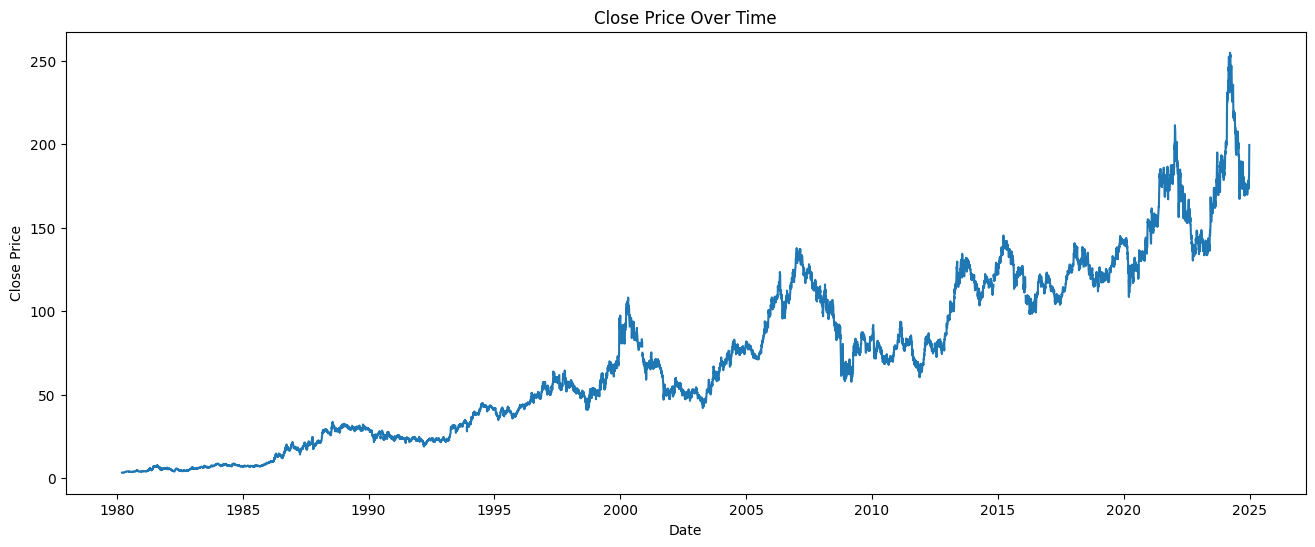

In [16]:
# Plot close price history 
plot_graph(data)

In [17]:
# Prepare data for training
values = data.filter(['Close']).values
train_len = int(np.ceil(len(values) * .98))
scaled, scaler = scale_data(values)

In [18]:
# Training data
seq_len = 70
x_train, y_train = create_train_data(scaled[:train_len], seq_len)
x_train = reshape_data(x_train)

In [19]:
# Build and train model
model = make_model((x_train.shape[1], 1))
train_model(model, x_train, y_train)

C:\Users\lokud\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 142s 99ms/step - loss: 0.0024 - learning_rate: 0.0010
Epoch 2/2
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 111s 79ms/step - loss: 2.8437e-04 - learning_rate: 0.0010


In [20]:
# Test data
x_test = create_test_data(scaled, train_len, seq_len)
x_test = reshape_data(x_test)
y_test = values[train_len:, :]

In [21]:
# Predict
predicted_close = model.predict(x_test)
predicted_close = scaler.inverse_transform(predicted_close)

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 462ms/step


In [22]:
# RMSE
rmse = np.sqrt(np.mean(((predicted_close - y_test) ** 2)))
print(f'RMSE: {rmse:.4f}')

RMSE: 8.1916


C:\Users\lokud\AppData\Local\Temp\ipykernel_45280\4118823630.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_Close'] = predicted_close


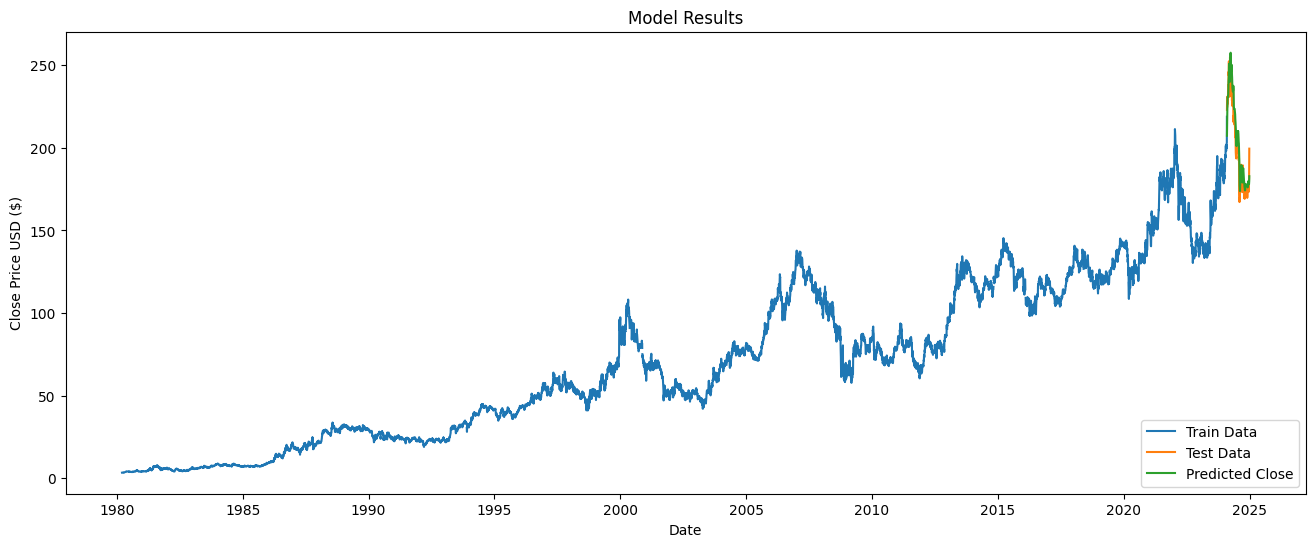

,Adj Close,Close,High,Low,Open,Volume,Predicted_Close
Date,,,,,,,
2024-02-07,223.050003,223.050003,224.020004,220.860001,222.339996,492700.0,207.352509
2024-02-08,226.309998,226.309998,226.399994,223.830002,225.320007,323000.0,211.025482
2024-02-09,224.460007,224.460007,225.139999,223.750000,223.820007,239100.0,215.731949
2024-02-12,225.860001,225.860001,226.869995,223.559998,223.820007,246300.0,220.298599
2024-02-13,231.000000,231.000000,232.559998,227.300003,227.589996,733400.0,224.096741
...,...,...,...,...,...,...,...
2024-12-20,178.169998,178.169998,179.919998,175.839996,175.839996,425700.0,177.954437
2024-12-23,180.449997,180.449997,180.619995,177.970001,179.119995,422700.0,177.918137
2024-12-24,181.429993,181.429993,181.720001,180.830002,181.000000,168600.0,178.607681


In [23]:
# Plot results
train_data = data[:train_len]
test_data = data[train_len:]
test_data['Predicted_Close'] = predicted_close
plot_results(train_data, test_data)

# Show test data
test_data